In [117]:
import numpy as np
from helpers import *
import cv2
import matplotlib.pyplot as plt

In [118]:
Ftrue = np.array([[ 3.07914555e-08, -3.61883689e-06,  5.43583727e-04],
       [-4.49876682e-06, -2.24402705e-08,  1.51520136e-01],
       [ 1.95223414e-03, -1.48295604e-01, -9.77264527e-01]])
Ftrue

array([[ 3.07914555e-08, -3.61883689e-06,  5.43583727e-04],
       [-4.49876682e-06, -2.24402705e-08,  1.51520136e-01],
       [ 1.95223414e-03, -1.48295604e-01, -9.77264527e-01]])

In [119]:
data = np.load("data/qs.npy", allow_pickle=True)
data

array({'q1': array([[192.80308677, 383.84844629, 552.40550165, 395.55690526,
        416.17883753, 366.71606701, 649.12832188, 437.85457401],
       [482.655306  , 522.55261707, 373.4083753 , 550.57520093,
        157.95394133, 379.58268042, 141.20188192, 571.00584606],
       [  1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ]]), 'q2': array([[ 77.42041221, 254.60721249, 469.08032639, 278.08133782,
        308.0810652 , 270.86822192, 508.91666875, 288.72429284],
       [479.74166846, 521.16039433, 373.38678026, 549.34478578,
        157.66285399, 378.83939131, 138.78418921, 569.99677028],
       [  1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ]])},
      dtype=object)

In [120]:
q1 = np.array([[192.80308677, 383.84844629, 552.40550165, 395.55690526,
        416.17883753, 366.71606701, 649.12832188, 437.85457401],
       [482.655306  , 522.55261707, 373.4083753 , 550.57520093,
        157.95394133, 379.58268042, 141.20188192, 571.00584606],
       [  1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ]]).T
q2 = np.array([[ 77.42041221, 254.60721249, 469.08032639, 278.08133782,
        308.0810652 , 270.86822192, 508.91666875, 288.72429284],
       [479.74166846, 521.16039433, 373.38678026, 549.34478578,
        157.66285399, 378.83939131, 138.78418921, 569.99677028],
       [  1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ]]).T
q1.shape,q2.shape
q1

array([[192.80308677, 482.655306  ,   1.        ],
       [383.84844629, 522.55261707,   1.        ],
       [552.40550165, 373.4083753 ,   1.        ],
       [395.55690526, 550.57520093,   1.        ],
       [416.17883753, 157.95394133,   1.        ],
       [366.71606701, 379.58268042,   1.        ],
       [649.12832188, 141.20188192,   1.        ],
       [437.85457401, 571.00584606,   1.        ]])

In [121]:
def normalize2d(x):
    return (x - x.mean()) / x.std()

In [122]:
Ftrue

array([[ 3.07914555e-08, -3.61883689e-06,  5.43583727e-04],
       [-4.49876682e-06, -2.24402705e-08,  1.51520136e-01],
       [ 1.95223414e-03, -1.48295604e-01, -9.77264527e-01]])

In [161]:
Bs = []
for i,(p, q) in enumerate(zip(q1, q2)):
    B = np.array([
        p[0]*q[0], p[0]*q[1], p[0], p[1]*q[0], p[1]*q[1], p[1], q[0], q[1], 1
    ])
    Bs.append(B)
U, S, V = np.linalg.svd(np.array(Bs))
Fe = V[-1].reshape(3, 3).T * -1 # why -1?
Ftrue/Fe, np.linalg.norm(Fe-Ftrue), np.linalg.norm(Fest_8point(q2,q1)-Ftrue)

(array([[1.00011889, 0.99999084, 0.99996574],
        [1.00000539, 1.00002486, 1.00000024],
        [1.00000639, 1.00000024, 0.99999999]]),
 5.6098940664854966e-08,
 0.42400811522254217)

In [124]:
data = np.load("data/TwoImageData.npy",allow_pickle=True).item()
im1,im2,R1,R2,t1,t2,K = data['im1'] ,data["im2"] ,data["R1"] ,data["R2"] ,data["t1"] ,data["t2"] ,data["K"]

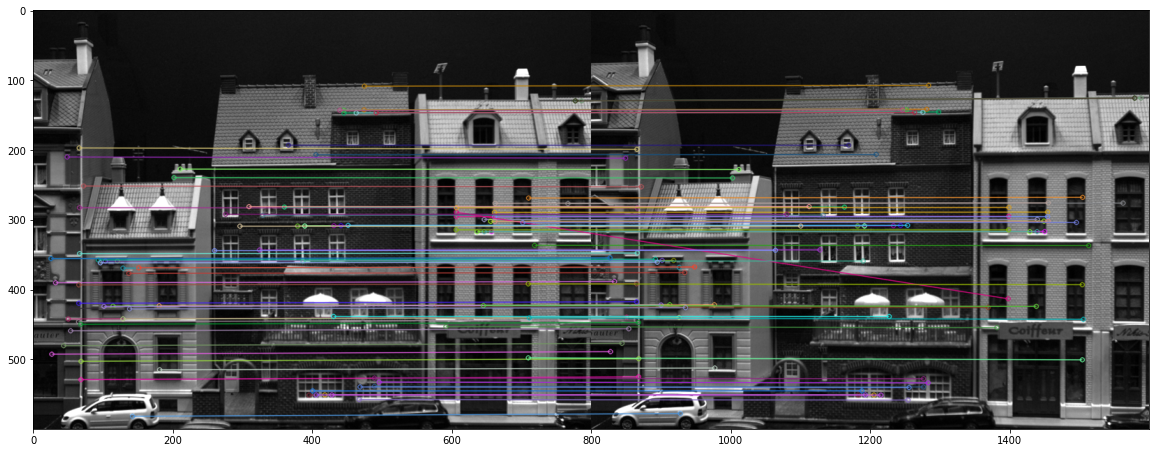

In [125]:
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)
bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des, des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(im1,kp,im2,kp2,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(img3)

In [143]:
len(kp),len(kp2)

(3749, 3628)

In [194]:
good = matches[:500]
P1 = np.array([[kp2[m.trainIdx].pt[0],kp2[m.trainIdx].pt[1],1] for m in good])
P2 = np.array([[kp[m.queryIdx].pt[0],kp[m.queryIdx].pt[1],1] for m in good])
threshold = 3.84 * 3**2
max_inliers = 0
Fest = None
for i in range(100):
    choice  = np.random.choice(good, 8, replace=False)
    points1 = np.array([[kp2[m.trainIdx].pt[0],kp2[m.trainIdx].pt[1],1] for m in choice])
    points2 = np.array([[kp[m.queryIdx].pt[0],kp[m.queryIdx].pt[1],1] for m in choice])
    F = Fest_8point(points2,points1)
    inliers = 0
    for p1,p2 in zip(P1,P2):
        sq1 = (p2 @ F)**2
        sq2 = (F @ p1.reshape(-1,1))**2
        d = (p2 @ F @ p1.reshape(-1,1))**2 / (sq1[:2].sum() + sq2[:2].sum())
        if d < threshold:
            inliers += 1
    if inliers > max_inliers:
        max_inliers = inliers
        Fest = F
        dist = np.linalg.norm(Fest-Ftrue)
        print(dist)
max_inliers,(Fest*Ftrue).sum() / (np.linalg.norm(Fest)*np.linalg.norm(Ftrue)), Fest/Ftrue

0.046180908222920466
0.09631806659517354
0.23438503644704137
0.055853188570559986
0.17590700056981692
0.1761216693754217


(483,
 0.9844905787901187,
 array([[-243.18135554,  190.12839775,  172.17788509],
        [-150.37529036, -620.79382017,    1.51537355],
        [ -43.5915497 ,    1.56564853,    0.95847143]]))

In [169]:
dist = np.linalg.norm(Fest-Ftrue)
dist,Ftrue,Fest

(0.037649845789690155,
 array([[ 3.07914555e-08, -3.61883689e-06,  5.43583727e-04],
        [-4.49876682e-06, -2.24402705e-08,  1.51520136e-01],
        [ 1.95223414e-03, -1.48295604e-01, -9.77264527e-01]]),
 array([[-5.36305864e-08, -4.83909018e-05,  1.90805257e-02],
        [ 3.80726699e-05,  9.61927984e-07,  1.70251747e-01],
        [-1.59090628e-02, -1.67318228e-01, -9.70773807e-01]]))

In [127]:
F = Fest_8point(q1,q2)

In [128]:
p1 = q1[0]
p2 = q2[0]
sq1 = (p2 @ F)**2
sq2 = (F @ p1)**2
d = (p1 @ F @ p2.reshape(-1,1))**2 / (sq1[:2].sum() + sq2[:2].sum())
d

array([12.88484512])